In [1]:
import os
import importlib
from PIL import Image
import torch
import importlib

os.chdir('/home/chenyun/work1/Clip')
!pwd
!echo $CUDA_VISIBLE_DEVICES
!nvidia-smi

/home/chenyun/work1/Clip
7
Fri Aug 27 02:07:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1A:00.0 Off |                  Off |
| 33%   56C    P2   118W / 260W |   1652MiB / 48601MiB |     39%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |     

In [2]:
import numpy as np

vocab = np.load('dependencies/VisDiff/vocabulary/word_vocab_train_5.npy', allow_pickle=True)

In [3]:
len(vocab.item())

730

In [4]:
# import clip

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)
# print('model ready.')

In [22]:
import json
data = json.load(open('data/VisDiff/visdiff_test.json'))

In [23]:
print(list(data.keys()))
print(data['annotations'][0])
print(len(data['annotations']))

['info', 'img_all_id', 'annotations']
{'img2_id': '0905533', 'img1_id': '0715395', 'sentences2': ['flying in the air', 'stabilizer bottom of the tail', 'facing left', 'small size', 'propeller engine'], 'id': 0, 'sentences1': ['on the ground', 'stabilizer top of the tail', 'facing right', 'medium size', 'turbo fan engine']}
2350


In [12]:
from utils.clip_encoder import ClipEncoder

clip_encoder = ClipEncoder()

ClipEncoder ready.


In [25]:
neg_samples = list()
pos_count = 0


# for template in ['A photo of an %s airplane',
#                  'A photo of an airplane with %s',
#                  'A photo of an airplane that is %s',
#                  'A photo of an airplane that has %s']:
for template in ['An image of an aircraft with %s']:
    print(template)
    for anno_i, anno in enumerate(data['annotations']):
        imgs = [Image.open('data/VisDiff/images/%s.jpg' % anno[k]).convert('RGB') for k in ['img1_id', 'img2_id']]
        img_feats = clip_encoder.encode_imgs(imgs)
        text1_feats = clip_encoder.encode_text_list([template % s for s in  anno['sentences1']])
        text2_feats = clip_encoder.encode_text_list([template % s for s in  anno['sentences2']])
        sims1 = (img_feats @ text1_feats.T).softmax(dim=0)
        sims2 = (img_feats @ text2_feats.T).softmax(dim=0)
        for ti in range(5):
            s11 = sims1[0, ti]
            s12 = sims2[0, ti] 
            s21 = sims1[1, ti]
            s22 = sims2[1, ti]
            p1 = s11 - s21
            p2 = s22 - s12
            if p1 + p2 > 0:
                pos_count += 1
            else:
                neg_samples.append((anno_i, ti))
        if anno_i % 100 == 0:
            print(anno_i, pos_count / (pos_count + len(neg_samples)), pos_count, len(neg_samples))

    print(anno_i, pos_count / (pos_count + len(neg_samples)), pos_count, len(neg_samples))
        

An image of an aircraft with %s
0 0.8 4 1
100 0.7128712871287128 360 145
200 0.7144278606965174 718 287
300 0.7196013289036545 1083 422
400 0.714713216957606 1433 572
500 0.7137724550898203 1788 717
600 0.7178036605657238 2157 848
700 0.7164051355206847 2511 994
800 0.7181023720349563 2876 1129
900 0.7216426193118757 3251 1254
1000 0.7208791208791209 3608 1397
1100 0.71952770208901 3961 1544
1200 0.7192339716902582 4319 1686
1300 0.7209838585703305 4690 1815
1400 0.7197715917201999 5042 1963
1500 0.7205862758161226 5408 2097
1600 0.7212991880074953 5774 2231
1700 0.7234567901234568 6153 2352
1800 0.7258189894503054 6536 2469
1900 0.7259337190952131 6900 2605
2000 0.7256371814092953 7260 2745
2100 0.7265111851499286 7632 2873
2200 0.7263062244434348 7993 3012
2300 0.7259452411994785 8352 3153
2349 0.7243404255319149 8511 3239


stabilizer top of the tail vs.  stabilizer bottom of the tail


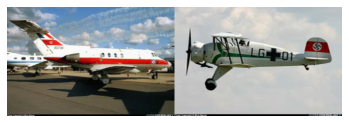

small size vs.  large size


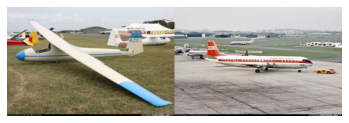

facing left vs.  facing right


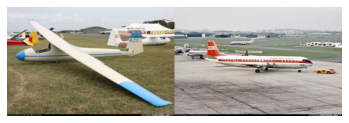

no windows vs.  windows


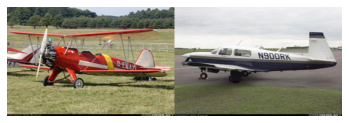

light in overall color vs.  dark in color


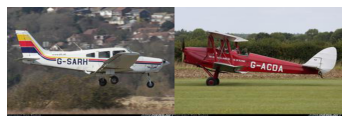

wings below seating area vs.  wings above and below seating area


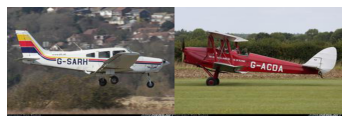

more doors vs.  one door


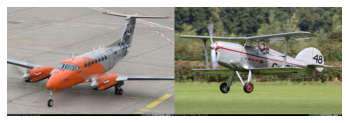

sharp nose vs.  small nose


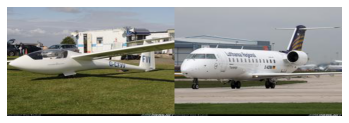

fewer windows on body vs.  more windows on body


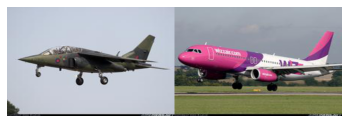

small plane vs.  larger plane


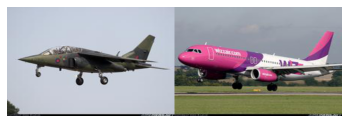

facing left vs.  facing right


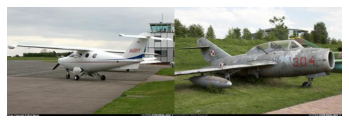

more windows on body vs.  fewer windows on body


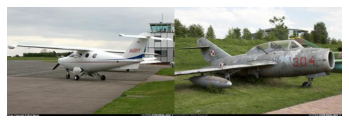

propellor engine vs.   turbofan engine


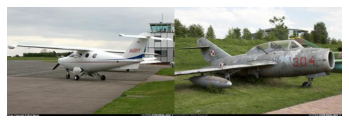

facing right vs.  facing left


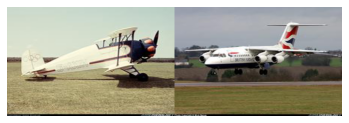

single seat vs.  passenger airliner


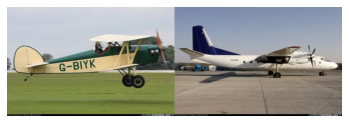

turbine on wings vs.  propellar on nose


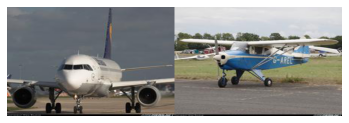

wings on bottom of plane vs.  wings on top of plane


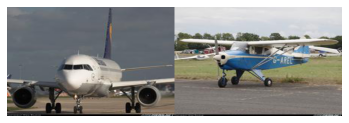

cannot see pilot in cockpit vs.  can see pilot in cockpit


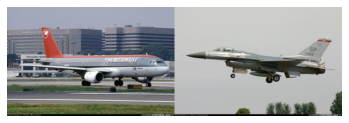

propellor vs.  turbofan


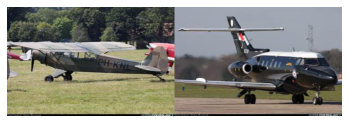

military plane vs.  passenger plane


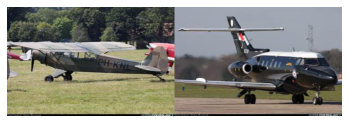

empty plane vs.  plane with pilot


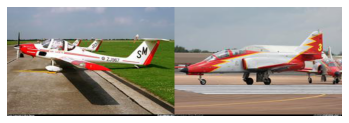

flat nose vs.  round nose


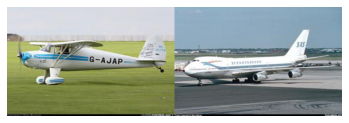

fewer windows on body vs.  more windows on body


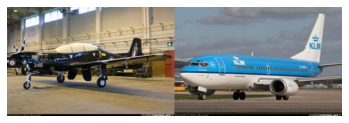

facing front vs.  facing right


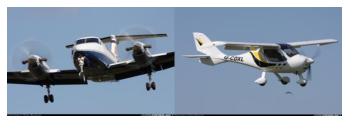

turbofan engine vs.  propellor engine


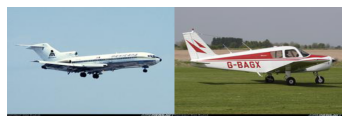

small nose vs.  larger nose


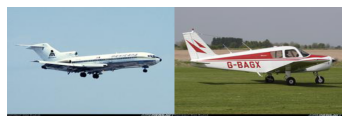

single engine vs.  twin engine


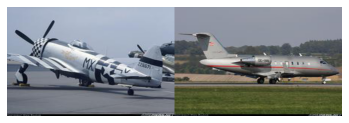

engine attached to wings vs.  engine attached to body below the wings


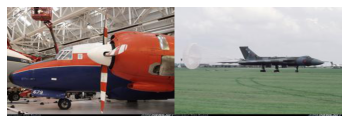

three-blade propellor fan vs.  two-blade propellor fan


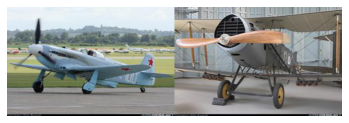

low-wing vs.  bi-wing


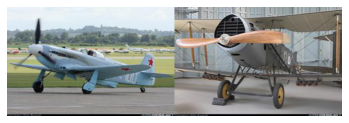

fewer windows on body vs.  more windows on body


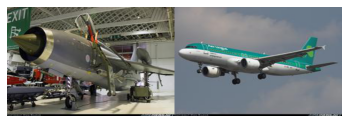

facing right vs.  facing left


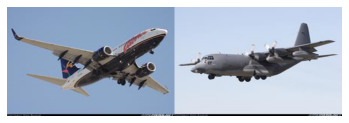

round nose vs.  sharp nose


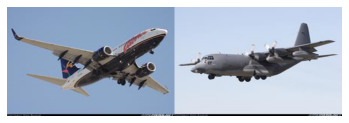

silver color vs.  white color


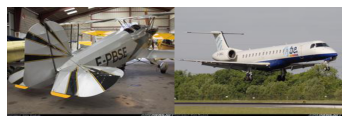

open window vs.  close window


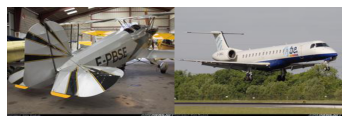

larger nose vs.  smaller nose


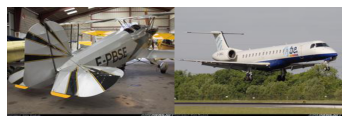

flat nose vs.  round nose


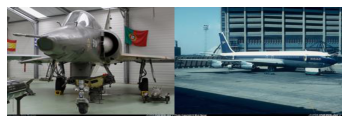

no windows vs.  more windows on body


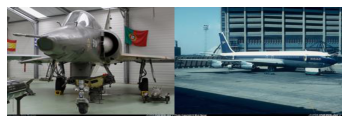

facing straight vs.  facing right


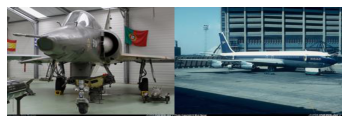

facing left vs.  facing left


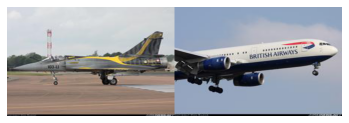

fewer windows on body vs.  more windows on body


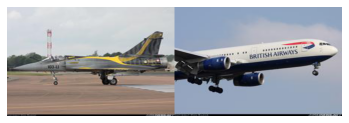

short nose vs.  long nose


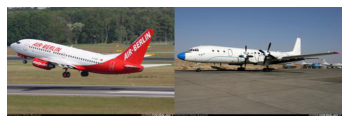

fewer windows on the body vs.  more windows on the body


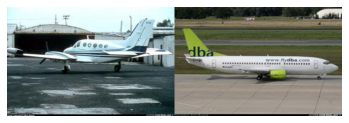

limited windows vs.  more windows


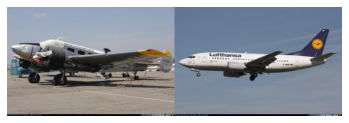

propelloer vs.  turbofan engine


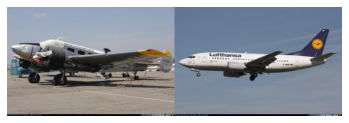

facing left vs.  facing right


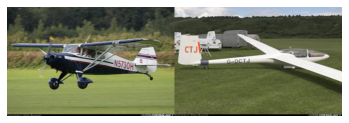

more windows on body vs.  no windows on body


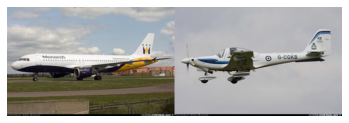

two wing propellers vs.  one front propeller


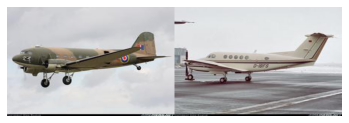

fewer windows vs.  more windows


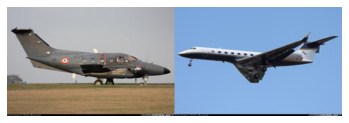

sharp nose vs.  round nose


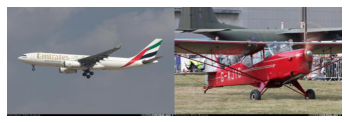

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for anno_i, ti in neg_samples[:50]:
    anno = data['annotations'][anno_i]
    print(anno['sentences1'][ti], 'vs. ', anno['sentences2'][ti])
    imgs = [Image.open('data/VisDiff/images/%s.jpg' % anno[k]).convert('RGB') for k in ['img1_id', 'img2_id']]
    imgs = [img.resize((400, 260)) for img in imgs]
    plt.figure(); plt.axis('off')
    plot_image = np.concatenate(imgs, axis=1)
    plt.imshow(plot_image)
    plt.show()


In [8]:
phrase_vocab = dict()  # phrase: [freq, neg_freq]
word_vocab = dict()

for anno in data['annotations']:
    for ph in anno['sentences1'] + anno['sentences2']:
        if ph in phrase_vocab:
            phrase_vocab[ph][0] += 1
        else:
            phrase_vocab[ph] = [1, 0]
        for w in ph.split():
            if w in word_vocab:
                word_vocab[w][0] += 1
            else:
                word_vocab[w] = [1, 0]

for anno_i, ti in neg_samples:        
    anno = data['annotations'][anno_i]
    for ph in [anno['sentences1'][ti], anno['sentences2'][ti]]:
        phrase_vocab[ph][1] += 1
        for w in ph.split():
            word_vocab[w][1] += 1
            

In [9]:
ph_s1 = sorted(phrase_vocab.items(), key=lambda ph_cc: -1 *ph_cc[1][0])
print(ph_s1[:10])

[('facing right', [692, 362]), ('facing left', [685, 353]), ('on the ground', [543, 46]), ('private plane', [430, 62]), ('small plane', [405, 84]), ('commercial plane', [405, 67]), ('flying in the air', [348, 27]), ('white color', [348, 33]), ('turbofan engine', [319, 68]), ('big plane', [244, 33])]


In [10]:
ph_s2 = sorted(phrase_vocab.items(), key=lambda ph_cc: -1 *ph_cc[1][1] / ph_cc[1][0])
ph_s2_freq = [x for x in ph_s2 if x[1][0] > 10]
print(len(ph_s2_freq))
print(ph_s2_freq[:50])
print(ph_s2_freq[-50:])

269
[('wings on the top of the body', [13, 10]), ('armed', [13, 10]), ('wings on top of body', [17, 13]), (' fewer windows on body', [16, 12]), ('unarmed', [12, 9]), ('windows', [11, 8]), ('high wing', [27, 19]), ('without commercial logo', [54, 38]), ('with logo', [30, 21]), ('low wing', [26, 18]), ('wings on the top and bottom of the body', [13, 9]), ('without logo', [26, 18]), ('wings on the bottom of the body', [16, 11]), ('with commercial logo', [67, 46]), ('engines next to the tail', [12, 8]), ('stabilizer on bottom of tail', [20, 13]), ('few passengers', [14, 9]), ('with military logo', [11, 7]), ('stabilizer on the top of the tail', [38, 24]), ('medium size plane', [19, 12]), ('wings on top', [43, 27]), ('larger', [21, 13]), ('long nose', [46, 28]), ('large in size', [15, 9]), ('one wheel in back', [20, 12]), ('stabilizer on the bottom of the tail', [37, 22]), ('closed cockpit', [74, 44]), ('wings on bottom', [22, 13]), ('smaller', [31, 18]), ('no pilot', [14, 8]), ('long wings

In [11]:
w_s2 = sorted(word_vocab.items(), key=lambda ph_cc: -1 *ph_cc[1][1] / ph_cc[1][0])
w_s2_freq = [x for x in w_s2 if x[1][0] > 10]
print(len(w_s2_freq))
print(w_s2_freq[:50])
print(w_s2_freq[-50:])

329
[('man', [11, 9]), ('covers', [20, 16]), ('armed', [17, 13]), ('unarmed', [12, 9]), ('blade', [17, 12]), ('turboprop', [16, 11]), ('next', [24, 16]), ('tires', [21, 14]), ('towards', [12, 8]), ('tyres', [26, 17]), ('high', [43, 28]), ('rear', [43, 28]), ('compartment', [11, 7]), ('without', [109, 69]), ('horizontal', [19, 12]), ('low', [46, 29]), ('sides', [27, 17]), ('coverings', [16, 10]), ('below', [55, 34]), ('domed', [13, 8]), ('behind', [13, 8]), ('top', [378, 226]), ('closed', [106, 63]), ('blades', [29, 17]), ('out', [26, 15]), ('picture', [26, 15]), ('seen', [16, 9]), ('away', [16, 9]), ('bottom', [264, 148]), ('middle', [22, 12]), ('open', [171, 93]), ('area', [13, 7]), ('low-wing', [26, 14]), ('stabilizers', [28, 15]), ('wheel', [271, 145]), ('logo', [330, 176]), ('covered', [96, 51]), ('very', [17, 9]), ('stabilizer', [278, 147]), ('cabin', [19, 10]), ('right', [852, 434]), ('wings', [866, 439]), ('left', [867, 438]), ('facing', [1840, 929]), ('seating', [18, 9]), ('win

In [12]:
from wordcloud import WordCloud
red_fn = lambda *args, **kwargs: "red"
blue_fn = lambda *args, **kwargs: "blue"
wc = WordCloud(background_color="white", prefer_horizontal=0.9, color_func=blue_fn, # colormap='tab20b',
               height=800, width=800,min_font_size=4, margin=2, font_path='output/DIN Alternate Bold.ttf')

ph_pos = {ph: np.log(cc[0]) for ph, cc in ph_s2_freq[-50:]}
wc.generate_from_frequencies(ph_pos)
wc.to_file('output/visdiff_pos.jpg')


In [13]:
wc.color_func=red_fn

ph_neg = {ph: np.log(cc[0]) for ph, cc in ph_s2_freq[:50]}
wc.generate_from_frequencies(ph_neg)
wc.to_file('output/visdiff_neg.jpg')